 Usando dispositivo: cpu
 PINN PROBLEMA INVERSO: IDENTIFICACIÓN DE PARÁMETROS

 OBJETIVO: Identificar difusividad térmica α desconocida
 ECUACIÓN: ∂u/∂t = α ∂²u/∂x²
 ENTRADA: Datos experimentales de temperatura dispersos
 SALIDA: α identificado + solución completa u(x,t)

 Generando datos experimentales sintéticos...
    50 mediciones experimentales generadas
    Valor verdadero α = 0.25
    Ruido experimental: 2%

 Creando modelo PINN inverso...
    Parámetros de red: 5302
    α inicial: 1.000000

 Entrenando PINN...
 Iniciando entrenamiento de PINN inversa...
 Valor verdadero de α: 0.25
 Valor inicial de α: 1.000000
------------------------------------------------------------
Época    0 | Pérdida: 0.590727 | α_pred: 0.999000 | Error α: 0.749000
Época  500 | Pérdida: 0.025708 | α_pred: 0.589930 | Error α: 0.339930
Época 1000 | Pérdida: 0.007489 | α_pred: 0.395693 | Error α: 0.145693
Época 1500 | Pérdida: 0.001935 | α_pred: 0.304776 | Error α: 0.054776
Época 2000 | Pérdida: 0.000850 | 

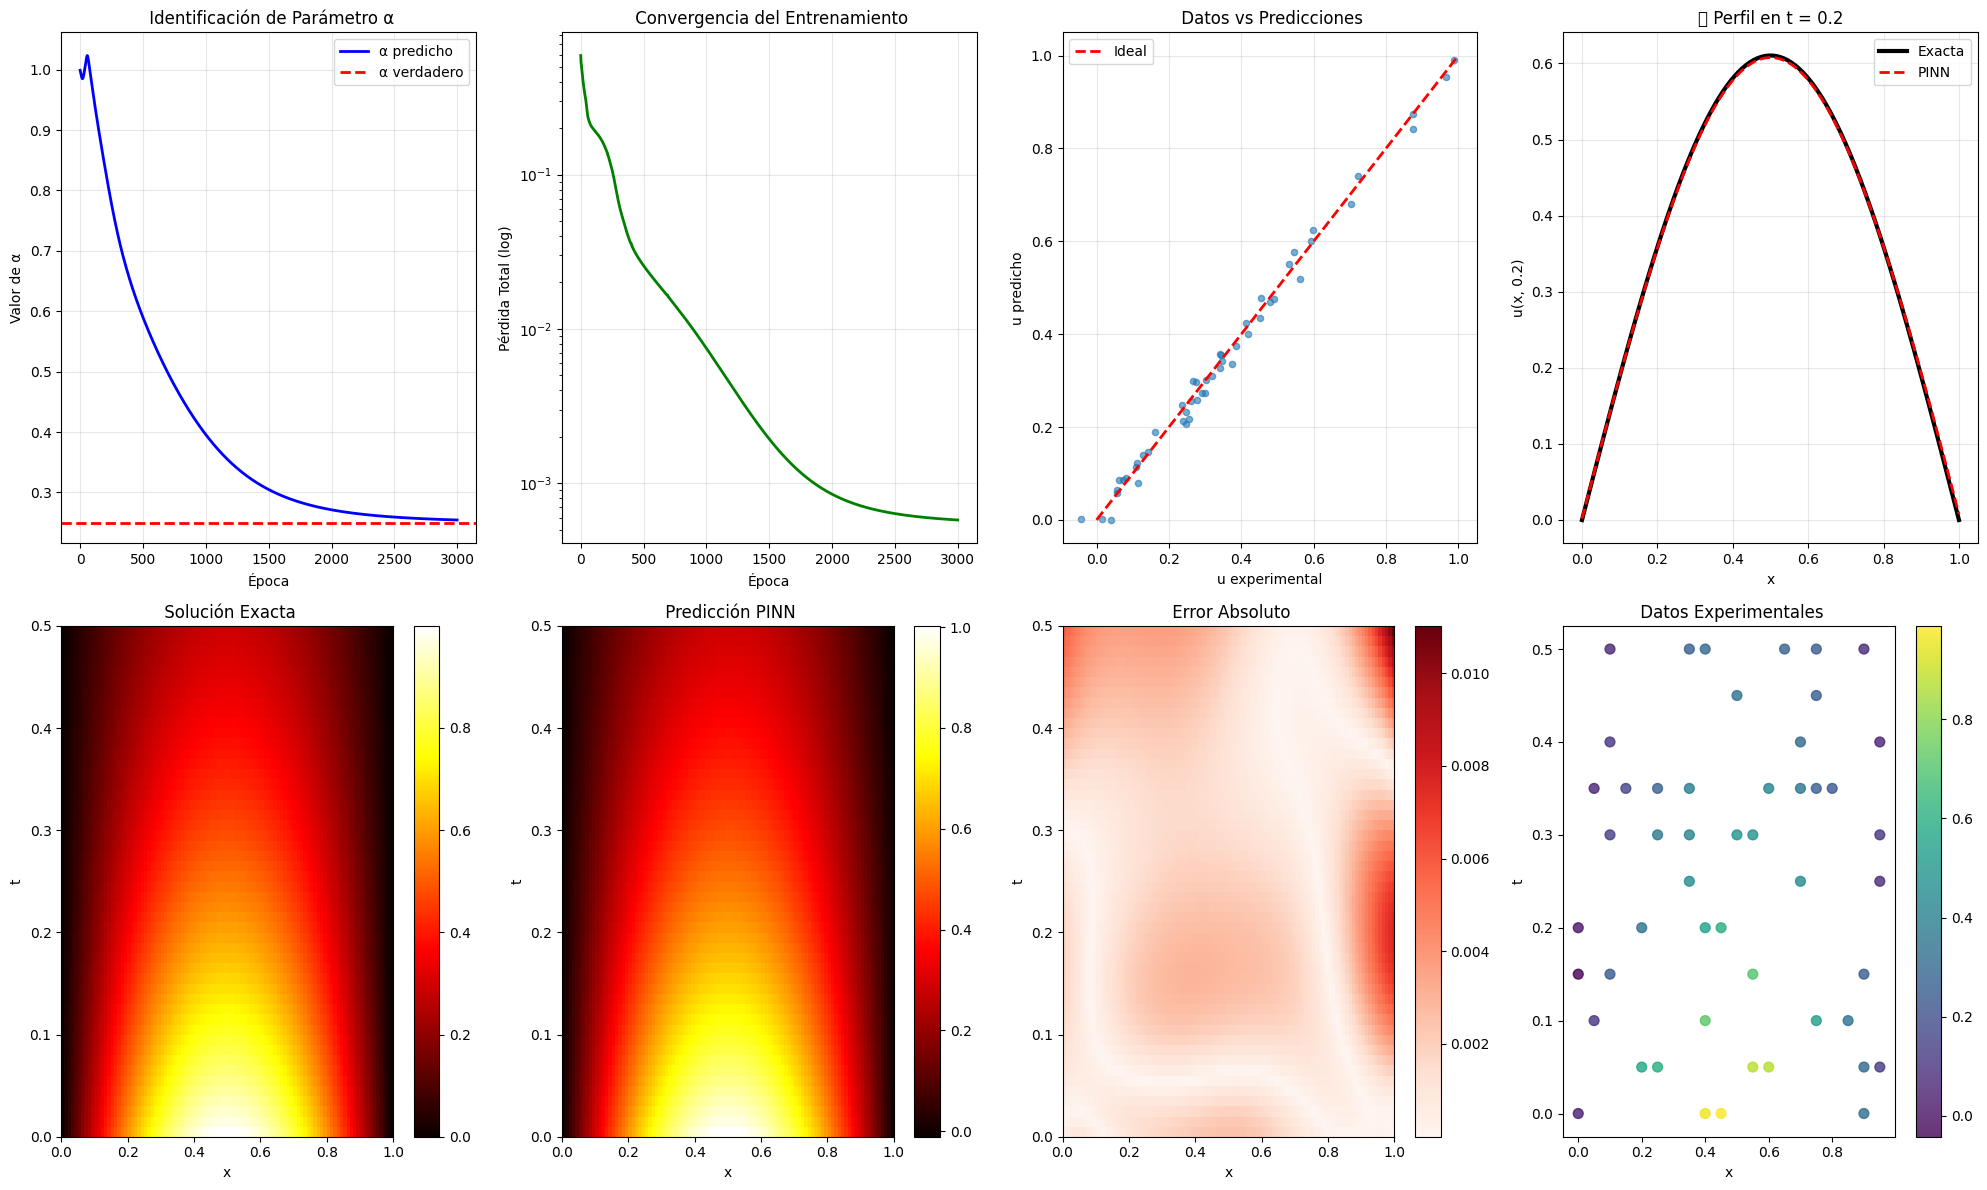


 LIMITACIÓN DE MÉTODOS TRADICIONALES

 DIFERENCIAS FINITAS para problema inverso:
   ∂u/∂t = α ∂²u/∂x²

    PROBLEMA: Necesita α conocido de antemano
    Sin α, no puede construir las ecuaciones
    Requiere proceso iterativo costoso:
      1. Adivinar α
      2. Resolver PDE completa
      3. Comparar con datos
      4. Ajustar α y repetir

 PINN RESUELVE AUTOMÁTICAMENTE:
    Identifica α y u(x,t) simultáneamente
    Una sola optimización
    Incorpora datos experimentales directamente

 RESUMEN FINAL
 α identificado correctamente: 0.254349
 Error en α: 1.74%
 Precisión de solución L2: 0.002145
 Tiempo total: 55.19 segundos

 VENTAJA CLAVE DE PINNs:
   • Identificación automática de parámetros
   • Incorporación directa de datos experimentales


In [2]:
"""
=============================================================================
PHYSICS-INFORMED NEURAL NETWORKS: PROBLEMA INVERSO
Identificación de Parámetros - Difusividad Térmica Desconocida
=============================================================================

PROBLEMA: Ecuación de calor con α desconocida
∂u/∂t = α ∂²u/∂x²

VENTAJA DE PINNs: Identifica α a partir de datos experimentales

"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import time
import warnings
warnings.filterwarnings('ignore')

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Usando dispositivo: {device}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

class InversePINN(nn.Module):
    """
    Physics-Informed Neural Network para Problema Inverso

    Características:
    - Aproxima u(x,t) con red neuronal
    - Identifica parámetro α desconocido
    - Incorpora física y datos experimentales simultáneamente
    """

    def __init__(self, layers=[2, 50, 50, 50, 1]):
        super().__init__()

        # ARQUITECTURA DE RED NEURONAL
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

        # PARÁMETRO DESCONOCIDO A IDENTIFICAR
        # α_true = 0.25, pero la red no lo sabe
        self.alpha = nn.Parameter(torch.tensor(1.0, device=device))

        # Inicialización Xavier para estabilidad
        for layer in self.layers[:-1]:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x, t):
        """
        Red neuronal: u(x,t) = NN(x,t)
        """
        inputs = torch.cat([x, t], dim=1)

        for i, layer in enumerate(self.layers[:-1]):
            inputs = torch.tanh(layer(inputs))

        # Capa final sin activación
        u = self.layers[-1](inputs)
        return u

    def physics_residual(self, x, t):
        """
        Calcula residuo de la ecuación física:
        R = ∂u/∂t - α ∂²u/∂x²

        Si R ≈ 0 en todos los puntos, la red satisface la física
        """
        # Habilitar gradientes para diferenciación automática
        x.requires_grad_(True)
        t.requires_grad_(True)

        u = self(x, t)

        # Primera derivada temporal: ∂u/∂t
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

        # Primera derivada espacial: ∂u/∂x
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

        # Segunda derivada espacial: ∂²u/∂x²
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

        # ECUACIÓN FÍSICA: ∂u/∂t = α ∂²u/∂x²
        residual = u_t - self.alpha * u_xx

        return residual

def generate_synthetic_data():
    """
    Genera datos sintéticos usando la solución analítica
    con α_true = 0.25 (valor que queremos recuperar)

    Solución exacta: u(x,t) = exp(-α π² t) sin(π x)
    """

    alpha_true = 0.25  #  VALOR VERDADERO A IDENTIFICAR

    # Dominio espacial y temporal
    x_data = torch.linspace(0, 1, 21).reshape(-1, 1)  # 21 puntos espaciales
    t_data = torch.linspace(0, 0.5, 11).reshape(-1, 1)  # 11 puntos temporales

    # Malla completa
    X_data, T_data = torch.meshgrid(x_data.squeeze(), t_data.squeeze(), indexing='ij')
    x_flat = X_data.flatten().reshape(-1, 1)
    t_flat = T_data.flatten().reshape(-1, 1)

    #  SOLUCIÓN ANALÍTICA EXACTA
    u_exact = torch.exp(-alpha_true * np.pi**2 * t_flat) * torch.sin(np.pi * x_flat)

    #  SIMULAR DATOS EXPERIMENTALES (con ruido)
    noise_level = 0.02  # 2% de ruido experimental
    noise = noise_level * torch.randn_like(u_exact)
    u_experimental = u_exact + noise

    # Seleccionar subset de datos experimentales (datos dispersos)
    n_data = 50  # Solo 50 mediciones de 231 posibles
    indices = torch.randperm(len(x_flat))[:n_data]

    x_exp = x_flat[indices].to(device)
    t_exp = t_flat[indices].to(device)
    u_exp = u_experimental[indices].to(device)

    return x_exp, t_exp, u_exp, alpha_true, x_flat, t_flat, u_exact

def train_inverse_pinn(model, x_exp, t_exp, u_exp, epochs=3000):
    """
    Entrena la PINN para problema inverso

    Función de pérdida multi-objetivo:
    L_total = λ₁ L_data + λ₂ L_physics + λ₃ L_ic + λ₄ L_bc
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

    # Puntos de colocación para física
    n_physics = 1000
    x_physics = torch.rand(n_physics, 1, device=device)
    t_physics = torch.rand(n_physics, 1, device=device) * 0.5

    # Condiciones de frontera e inicial
    n_boundary = 100

    # Condición inicial: t = 0
    x_ic = torch.rand(n_boundary, 1, device=device)
    t_ic = torch.zeros(n_boundary, 1, device=device)
    u_ic = torch.sin(np.pi * x_ic)  # u(x,0) = sin(πx)

    # Condiciones de frontera: u(0,t) = u(1,t) = 0
    t_bc = torch.rand(n_boundary, 1, device=device) * 0.5
    x_bc1 = torch.zeros(n_boundary, 1, device=device)  # x = 0
    x_bc2 = torch.ones(n_boundary, 1, device=device)   # x = 1

    # Almacenar historia del entrenamiento
    losses = []
    alpha_history = []

    print(" Iniciando entrenamiento de PINN inversa...")
    print(f" Valor verdadero de α: 0.25")
    print(f" Valor inicial de α: {model.alpha.item():.6f}")
    print("-" * 60)

    start_time = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()

        #  PÉRDIDA DE DATOS EXPERIMENTALES
        u_pred_data = model(x_exp, t_exp)
        loss_data = torch.mean((u_pred_data - u_exp)**2)

        #  PÉRDIDA FÍSICA (residuo de PDE)
        residual = model.physics_residual(x_physics, t_physics)
        loss_physics = torch.mean(residual**2)

        #  PÉRDIDA CONDICIÓN INICIAL
        u_pred_ic = model(x_ic, t_ic)
        loss_ic = torch.mean((u_pred_ic - u_ic)**2)

        #  PÉRDIDA CONDICIONES DE FRONTERA
        u_pred_bc1 = model(x_bc1, t_bc)
        u_pred_bc2 = model(x_bc2, t_bc)
        loss_bc = torch.mean(u_pred_bc1**2 + u_pred_bc2**2)

        #  PÉRDIDA TOTAL PONDERADA
        lambda_data = 1.0      # Peso datos experimentales
        lambda_physics = 0.1   # Peso física
        lambda_ic = 1.0        # Peso condición inicial
        lambda_bc = 1.0        # Peso condiciones frontera

        loss_total = (lambda_data * loss_data +
                     lambda_physics * loss_physics +
                     lambda_ic * loss_ic +
                     lambda_bc * loss_bc)

        # Backpropagation
        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Guardar historia
        losses.append(loss_total.item())
        alpha_history.append(model.alpha.item())

        # Progreso cada 500 épocas
        if epoch % 500 == 0:
            print(f"Época {epoch:4d} | "
                  f"Pérdida: {loss_total.item():.6f} | "
                  f"α_pred: {model.alpha.item():.6f} | "
                  f"Error α: {abs(model.alpha.item() - 0.25):.6f}")

    training_time = time.time() - start_time

    print("-" * 60)
    print(f" Entrenamiento completado en {training_time:.2f} segundos")
    print(f" α_verdadero = 0.25")
    print(f" α_predicho  = {model.alpha.item():.6f}")
    print(f" Error relativo = {abs(model.alpha.item() - 0.25) / 0.25 * 100:.2f}%")

    return losses, alpha_history, training_time

def evaluate_and_visualize(model, x_exp, t_exp, u_exp, alpha_true,
                          x_flat, t_flat, u_exact, losses, alpha_history):
    """
    Evaluación completa y visualización de resultados
    """

    print("\n" + "="*60)
    print(" EVALUACIÓN DE RESULTADOS")
    print("="*60)

    # Evaluación en malla fina para visualización
    x_test = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
    t_test = torch.linspace(0, 0.5, 50).reshape(-1, 1).to(device)
    X_test, T_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_eval = X_test.flatten().reshape(-1, 1)
    t_eval = T_test.flatten().reshape(-1, 1)

    # Predicciones del modelo
    with torch.no_grad():
        u_pred = model(x_eval, t_eval).cpu()

    # Solución exacta en malla fina
    u_exact_eval = np.exp(-alpha_true * np.pi**2 * t_eval.cpu().numpy()) * np.sin(np.pi * x_eval.cpu().numpy())
    u_exact_eval = torch.from_numpy(u_exact_eval).float()

    # Métricas de error
    error_l2 = torch.sqrt(torch.mean((u_pred - u_exact_eval)**2))
    error_max = torch.max(torch.abs(u_pred - u_exact_eval))
    error_alpha = abs(model.alpha.item() - alpha_true)
    error_alpha_rel = error_alpha / alpha_true * 100

    print(f" IDENTIFICACIÓN DE PARÁMETROS:")
    print(f"   α verdadero:  {alpha_true:.6f}")
    print(f"   α predicho:   {model.alpha.item():.6f}")
    print(f"   Error α:      {error_alpha:.6f}")
    print(f"   Error α (%):  {error_alpha_rel:.2f}%")
    print()
    print(f" PRECISIÓN DE SOLUCIÓN:")
    print(f"   Error L2:     {error_l2.item():.6f}")
    print(f"   Error máximo: {error_max.item():.6f}")

    # Crear visualización completa
    fig = plt.figure(figsize=(20, 12))

    # 1. Convergencia de α durante entrenamiento
    ax1 = plt.subplot(2, 4, 1)
    plt.plot(alpha_history, 'b-', linewidth=2, label='α predicho')
    plt.axhline(y=alpha_true, color='r', linestyle='--', linewidth=2, label='α verdadero')
    plt.xlabel('Época')
    plt.ylabel('Valor de α')
    plt.title(' Identificación de Parámetro α')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Convergencia de pérdida
    ax2 = plt.subplot(2, 4, 2)
    plt.semilogy(losses, 'g-', linewidth=2)
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total (log)')
    plt.title(' Convergencia del Entrenamiento')
    plt.grid(True, alpha=0.3)

    # 3. Datos experimentales vs predicciones
    ax3 = plt.subplot(2, 4, 3)
    u_pred_exp = model(x_exp, t_exp).detach().cpu()
    plt.scatter(u_exp.cpu(), u_pred_exp, alpha=0.6, s=20)
    plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ideal')
    plt.xlabel('u experimental')
    plt.ylabel('u predicho')
    plt.title(' Datos vs Predicciones')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Perfil de temperatura en t=0.2
    ax4 = plt.subplot(2, 4, 4)
    t_slice = 0.2
    x_slice = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
    t_slice_tensor = torch.full_like(x_slice, t_slice)

    with torch.no_grad():
        u_pred_slice = model(x_slice, t_slice_tensor).cpu()
    u_exact_slice = np.exp(-alpha_true * np.pi**2 * t_slice) * np.sin(np.pi * x_slice.cpu().numpy())

    plt.plot(x_slice.cpu(), u_exact_slice, 'k-', linewidth=3, label='Exacta')
    plt.plot(x_slice.cpu(), u_pred_slice, 'r--', linewidth=2, label='PINN')
    plt.xlabel('x')
    plt.ylabel('u(x, 0.2)')
    plt.title(f'🌡️ Perfil en t = {t_slice}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5-6. Mapas de calor comparativos
    u_pred_2d = u_pred.reshape(100, 50)
    u_exact_2d = u_exact_eval.reshape(100, 50)

    ax5 = plt.subplot(2, 4, 5)
    im1 = plt.imshow(u_exact_2d.T, extent=[0, 1, 0, 0.5],
                     aspect='auto', origin='lower', cmap='hot')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Solución Exacta')
    plt.colorbar(im1, ax=ax5)

    ax6 = plt.subplot(2, 4, 6)
    im2 = plt.imshow(u_pred_2d.T, extent=[0, 1, 0, 0.5],
                     aspect='auto', origin='lower', cmap='hot')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Predicción PINN')
    plt.colorbar(im2, ax=ax6)

    # 7. Mapa de error
    ax7 = plt.subplot(2, 4, 7)
    error_2d = torch.abs(u_pred_2d - u_exact_2d)
    im3 = plt.imshow(error_2d.T, extent=[0, 1, 0, 0.5],
                     aspect='auto', origin='lower', cmap='Reds')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Error Absoluto')
    plt.colorbar(im3, ax=ax7)

    # 8. Distribución de datos experimentales
    ax8 = plt.subplot(2, 4, 8)
    scatter = plt.scatter(x_exp.cpu(), t_exp.cpu(), c=u_exp.cpu(),
                         cmap='viridis', s=50, alpha=0.8)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Datos Experimentales')
    plt.colorbar(scatter, ax=ax8)

    plt.tight_layout()
    plt.show()

    return {
        'error_l2': error_l2.item(),
        'error_max': error_max.item(),
        'error_alpha': error_alpha,
        'error_alpha_rel': error_alpha_rel,
        'alpha_predicted': model.alpha.item()
    }

def demonstrate_traditional_method_limitation():
    """
    Demuestra por qué los métodos tradicionales NO pueden resolver
    el problema inverso directamente
    """

    print("\n" + "="*60)
    print(" LIMITACIÓN DE MÉTODOS TRADICIONALES")
    print("="*60)
    print()
    print(" DIFERENCIAS FINITAS para problema inverso:")
    print("   ∂u/∂t = α ∂²u/∂x²")
    print()
    print("    PROBLEMA: Necesita α conocido de antemano")
    print("    Sin α, no puede construir las ecuaciones")
    print("    Requiere proceso iterativo costoso:")
    print("      1. Adivinar α")
    print("      2. Resolver PDE completa")
    print("      3. Comparar con datos")
    print("      4. Ajustar α y repetir")
    print()
    print(" PINN RESUELVE AUTOMÁTICAMENTE:")
    print("    Identifica α y u(x,t) simultáneamente")
    print("    Una sola optimización")
    print("    Incorpora datos experimentales directamente")


def main():
    """
    Función principal - Ejecuta el ejemplo completo
    """

    print("="*70)
    print(" PINN PROBLEMA INVERSO: IDENTIFICACIÓN DE PARÁMETROS")
    print("="*70)
    print()
    print(" OBJETIVO: Identificar difusividad térmica α desconocida")
    print(" ECUACIÓN: ∂u/∂t = α ∂²u/∂x²")
    print(" ENTRADA: Datos experimentales de temperatura dispersos")
    print(" SALIDA: α identificado + solución completa u(x,t)")
    print()

    # 1. Generar datos sintéticos
    print(" Generando datos experimentales sintéticos...")
    x_exp, t_exp, u_exp, alpha_true, x_flat, t_flat, u_exact = generate_synthetic_data()

    print(f"    {len(x_exp)} mediciones experimentales generadas")
    print(f"    Valor verdadero α = {alpha_true}")
    print(f"    Ruido experimental: 2%")

    # 2. Crear modelo PINN
    print("\n Creando modelo PINN inverso...")
    model = InversePINN().to(device)
    print(f"    Parámetros de red: {sum(p.numel() for p in model.parameters())}")
    print(f"    α inicial: {model.alpha.item():.6f}")

    # 3. Entrenar modelo
    print("\n Entrenando PINN...")
    losses, alpha_history, training_time = train_inverse_pinn(
        model, x_exp, t_exp, u_exp, epochs=3000
    )

    # 4. Evaluar y visualizar
    results = evaluate_and_visualize(
        model, x_exp, t_exp, u_exp, alpha_true,
        x_flat, t_flat, u_exact, losses, alpha_history
    )

    # 5. Demostrar limitación de métodos tradicionales
    demonstrate_traditional_method_limitation()

    # 6. Resumen final
    print("\n" + "="*60)
    print(" RESUMEN FINAL")
    print("="*60)
    print(f" α identificado correctamente: {results['alpha_predicted']:.6f}")
    print(f" Error en α: {results['error_alpha_rel']:.2f}%")
    print(f" Precisión de solución L2: {results['error_l2']:.6f}")
    print(f" Tiempo total: {training_time:.2f} segundos")
    print()
    print(" VENTAJA CLAVE DE PINNs:")
    print("   • Identificación automática de parámetros")
    print("   • Incorporación directa de datos experimentales")

if __name__ == "__main__":
    main()